In [1]:
# Data Analysis
import pandas as pd

# Data Visualization
from matplotlib import pyplot as plt
from matplotlib import cm

# Reliability
from reliability.Fitters import Fit_Everything, Fit_Weibull_3P
from reliability.Reliability_testing import KStest
from reliability.Distributions import Weibull_Distribution, Lognormal_Distribution, Exponential_Distribution
from reliability.Probability_plotting import plot_points
from statsmodels.distributions.empirical_distribution import ECDF

# Utilities
import os
import numpy as np
from tqdm import tnrange
from tqdm import tqdm_notebook as tqdmn

# %matplotlib notebook
# from IPython.core.interactiveshell import InteractiveShell

## Utility functions

In [2]:
def sensitivity_analysis(dataframe, c_wins, filepath):
    if(not os.path.isfile(filepath)):
        print('Creating file',filepath, 'this may take a while...\n')
        tuples = []

        for win in c_wins:
            tup = 1
            prev = int(dataframe.loc[0,'Timestamp'])

            for index in range(dataframe.shape[0]-1):
                succ = int(dataframe.loc[index+1,'Timestamp'])
                if  succ - prev >= win:
                    tup = tup + 1
                prev = succ
  
            tuples.append(tup)
        
        df_sens = pd.DataFrame(data = {'Window' : c_wins, 'Tuples' : tuples})
        df_sens.to_csv(filepath)

    else:
        print('File already exists!\n')
        df_sens = pd.read_csv(filepath, index_col = 0)
    
    return df_sens      

In [3]:
def tupling(dataframe, c_win, filepath):
    if(not os.path.isfile(filepath)):
        print('Creating file', filepath, 'this may take a while...\n')
        
        tup = 0
        prev = int(dataframe.loc[0,'Timestamp'])
        dataframe.loc[0,'Tuple'] = 0

        for index in range(dataframe.shape[0]-1):
            succ = int(dataframe.loc[index+1,'Timestamp'])
            if  succ - prev >= c_win:
                tup = tup + 1
            dataframe.loc[index+1,'Tuple'] = tup
            prev = succ
            
        dataframe.to_csv(filepath)

    else:
        print('File already exists!\n')
        dataframe = pd.read_csv(filepath, index_col = 0)
    
    return dataframe

In [4]:
def statistics(dataframe):
    df_stat = pd.DataFrame(columns=['# Entries', 'Start time', 'End time', 'Length', 'Density', 'Interarrival'])

    df_stat['# Entries'] = dataframe.groupby(by='Tuple').count()['Timestamp']
    df_stat['Start time'] =  dataframe.groupby(by='Tuple').min(numeric_only = True)['Timestamp']
    df_stat['End time'] =  dataframe.groupby(by='Tuple').max(numeric_only = True)['Timestamp']
    df_stat['Length'] =  df_stat['End time'] - df_stat['Start time']
    df_stat['Density'] = df_stat['# Entries'] / df_stat['Length']
    df_temp = pd.DataFrame(data = {'Start time' : [np.nan]})
    df_temp = df_temp.append(df_stat, ignore_index = True)
    df_stat['Interarrival'] = (df_stat['Start time'] - df_temp['End time']).dropna().astype(int)
        
    return df_stat

## Load Data

In [5]:
df_bgl = pd.read_csv('./BGLErrorLog.txt', names = ['Timestamp', 'ID-Node','Rack', 'Midplane', 'Node', 'Card', 'Card type', 'Message'])

df_bgl.loc[:,'ID-Node'] = df_bgl.loc[:,'Timestamp'].str.split(' ', n=3).str[1]

df_bgl.loc[:,'Rack'] = df_bgl.loc[:,'ID-Node'].str.split('-', n=2).str[0]
df_bgl.loc[:,'Midplane'] = df_bgl.loc[:,'ID-Node'].str.split('-', n=2).str[1]
df_bgl.loc[:,'Node'] = df_bgl.loc[:,'ID-Node'].str.split('-', n=2).str[2]

df_bgl.loc[:,'Card'] = df_bgl.loc[:,'Timestamp'].str.split(' ', n=3).str[2]

df_bgl.loc[df_bgl['Card'].str.contains('J18'),'Card type'] = 'I-O'
df_bgl.loc[~df_bgl['Card'].str.contains('J18'),'Card type'] = 'computation'

# df_bgl.loc[:,'Card type'] = df_bgl.loc[:,'Card'].str.split('-', n=1).str[0]

df_bgl.loc[:,'Message'] = df_bgl.loc[:,'Timestamp'].str.split(' ', n=3).str[3].str.strip()
df_bgl.loc[:,'Timestamp'] = df_bgl.loc[:,'Timestamp'].str.split(' ', n=3).str[0]

print('Log file has ' + str(df_bgl.shape[0]) + ' entries and ' + str(df_bgl.shape[1]) + ' columns.')
df_bgl.head()

/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/3415615146.py:1: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_bgl = pd.read_csv('./BGLErrorLog.txt', names = ['Timestamp', 'ID-Node','Rack', 'Midplane', 'Node', 'Card', 'Card type', 'Message'])


Log file has 125624 entries and 8 columns.


,Timestamp,ID-Node,Rack,Midplane,Node,Card,Card type,Message
0,1128621350,R00-M0-N0,R00,M0,N0,J18-U01,I-O,Lustre mount FAILED : bglio2 : block_id : loca...
1,1128621350,R01-M1-N0,R01,M1,N0,J18-U11,I-O,Lustre mount FAILED : bglio21 : block_id : loc...
2,1128621351,R07-M0-NC,R07,M0,NC,J18-U01,I-O,Lustre mount FAILED : bglio124 : block_id : lo...
3,1128621351,R00-M0-N4,R00,M0,N4,J18-U01,I-O,Lustre mount FAILED : bglio4 : block_id : loca...
4,1128621351,R02-M0-N4,R02,M0,N4,J18-U01,I-O,Lustre mount FAILED : bglio36 : block_id : loc...


# System (Blue Gene/L)

## Data Manipulation

### Temporal coalescence

#### Sensitivity analysis

File already exists!



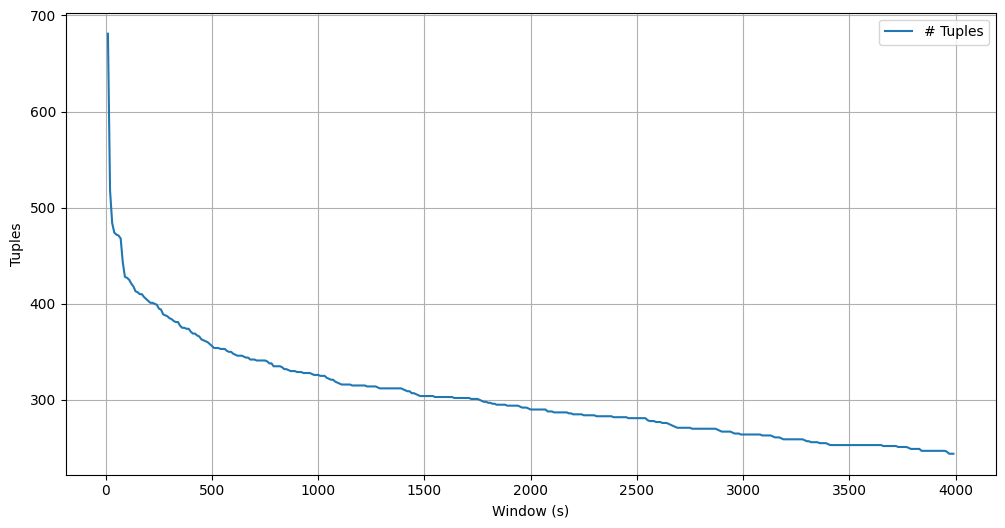

In [6]:
c_wins = np.delete(np.arange(0,4000,10), 0)

filepath = './data/system/BGL-Sensitivity.csv'

df_bgl_sensitivity = sensitivity_analysis(df_bgl, c_wins, filepath)

plt.figure(figsize=(12,6))
plt.plot(df_bgl_sensitivity['Window'],df_bgl_sensitivity['Tuples'], label = '# Tuples')
plt.xlabel('Window (s)')
plt.ylabel('Tuples')
plt.legend()
plt.grid()
plt.savefig("./img/system/BGL_System_Sensitivity.png", format = "png")
plt.show()

#### Tupling

In [7]:
window = 500

filepath = './data/system/BGL-Data.csv'

df_bgl = tupling(df_bgl, window, filepath)
df_bgl = df_bgl.astype({'Timestamp' : 'int32', 'Tuple' : 'int32'})
df_bgl.head()

File already exists!



,Timestamp,ID-Node,Rack,Midplane,Node,Card,Card type,Message,Tuple
0,1128621350,R00-M0-N0,R00,M0,N0,J18-U01,I-O,Lustre mount FAILED : bglio2 : block_id : loca...,0
1,1128621350,R01-M1-N0,R01,M1,N0,J18-U11,I-O,Lustre mount FAILED : bglio21 : block_id : loc...,0
2,1128621351,R07-M0-NC,R07,M0,NC,J18-U01,I-O,Lustre mount FAILED : bglio124 : block_id : lo...,0
3,1128621351,R00-M0-N4,R00,M0,N4,J18-U01,I-O,Lustre mount FAILED : bglio4 : block_id : loca...,0
4,1128621351,R02-M0-N4,R02,M0,N4,J18-U01,I-O,Lustre mount FAILED : bglio36 : block_id : loc...,0


In [8]:
num_tuple = df_bgl.max(axis = 0).loc['Tuple'] + 1
print('Number of tuples: ', num_tuple)

Number of tuples:  356


/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/2052055457.py:1: FutureWarning: The default value of numeric_only in DataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  num_tuple = df_bgl.max(axis = 0).loc['Tuple'] + 1


In [9]:
df_sys_stat = statistics(df_bgl)
df_sys_stat.head()

/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/1049074867.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(df_stat, ignore_index = True)


,# Entries,Start time,End time,Length,Density,Interarrival
Tuple,,,,,,
0,128,1128621350,1128621367,17,7.52941,NaN
1,1024,1128641281,1128641411,130,7.87692,19914
2,23,1128702415,1128702464,49,0.469388,61004
3,9,1128719240,1128719316,76,0.118421,16776
4,14,1128747957,1128748024,67,0.208955,28641


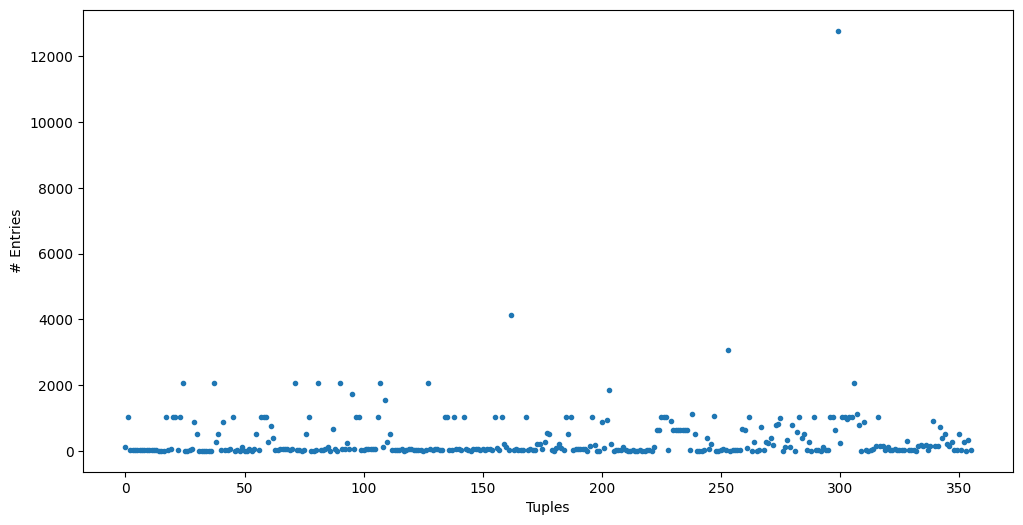

In [10]:
x = df_sys_stat.index
y = df_sys_stat['# Entries']

plt.figure(figsize=(12,6))
plt.scatter(x, y, marker = '.')
plt.xlabel('Tuples')
plt.ylabel('# Entries')
plt.savefig("./img/system/BGL_System_Scatter_Entry.svg", format = "svg")
plt.show()

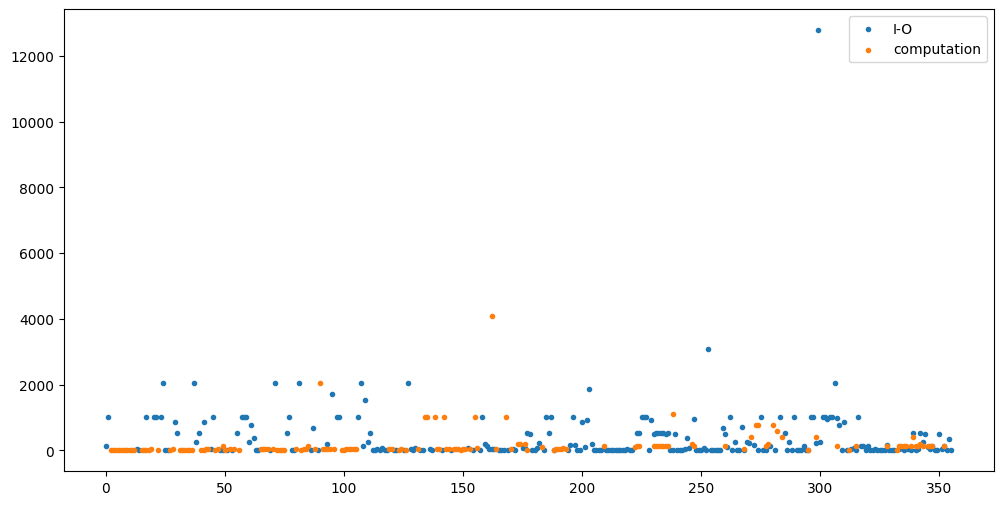

In [11]:
df_group = df_bgl.groupby(by=['Tuple','Card type']).count()

# cmap = cm.get_cmap('tab20')
# colors = cmap.colors

fig, ax = plt.subplots(figsize=(12,6))
# ax.set_prop_cycle(color=colors)

for card in df_bgl['Card type'].unique():
    df_temp = df_group[df_group.index.get_level_values('Card type').isin([card])]
    
    x = df_temp.index.get_level_values(0)
    y = df_temp['Timestamp']
    
    plt.scatter(x,y, label=card, marker = '.')

    
plt.legend()
plt.savefig("./img/system/BGL_System_Scatter_CardType.svg", format = "svg")
plt.show()

### Truncation analysis

In [10]:
q = df_sys_stat['Interarrival'].quantile(q=0.1)
print("0.1 quantile: " + str(q))

0.1 quantile: 1073.6


In [11]:
df_trunc = df_sys_stat.loc[df_sys_stat['Interarrival'] <= q]
df_trunc.head()

,# Entries,Start time,End time,Length,Density,Interarrival
Tuple,,,,,,
7,20,1128801670,1128801722,52,0.384615,828
14,1,1128944032,1128944032,0,inf,969
21,1024,1129166602,1129166717,115,8.90435,647
35,2,1129300645,1129300645,0,inf,851
36,2,1129301206,1129301206,0,inf,561


In [14]:
num_trunc = df_trunc.shape[0]
perc_trunc = (num_trunc/num_tuple)*100

print('Estimate number of truncations:', num_trunc)
print('Estimate percentage of truncations:', perc_trunc)

Estimate number of truncations: 36
Estimate percentage of truncations: 10.112359550561797


### Collision analysis

In [15]:
df_group = df_bgl.groupby(by=['Tuple','Rack']).count()
df_group = df_group.reset_index(level = 1)

collided = 0
for tup in df_group.index.unique():
    if df_group.loc[df_group.index == tup].shape[0] > 1:
        collided = collided + 1

In [16]:
perc_coll = (collided/num_tuple)*100

print('Estimate number of collisions:', collided)
print('Estimate percentage of collisions: ', perc_coll)

Estimate number of collisions: 177
Estimate percentage of collisions:  49.71910112359551


In [17]:
df_group = df_bgl.groupby(by=['Tuple','Card type']).count()
df_group = df_group.reset_index(level = 1)

collided = 0
for tup in df_group.index.unique():
    if df_group.loc[df_group.index == tup].shape[0] > 1:
        collided = collided + 1

In [18]:
perc_coll = (collided/num_tuple)*100

print('Estimate number of collisions:', collided)
print('Estimate percentage of collisions: ', perc_coll)

Estimate number of collisions: 43
Estimate percentage of collisions:  12.07865168539326


## Data Analysis

### Empirical time to failure distribution

### Empirical reliability

In [13]:
data_bgl = df_sys_stat['Interarrival'].dropna().to_numpy()

ecdf = ECDF(data_bgl)

tempi_int = pd.DataFrame(df_sys_stat['Interarrival'].dropna().to_numpy(), columns=['tempi interarrivo'])
np.savetxt(r'./scripts_matlab/system/tempi_int.txt', tempi_int, fmt='%d')

# Top Racks

In [14]:
print('Number of racks that generates error: ' + str(len(df_bgl['Rack'].unique())))

Number of racks that generates error: 64


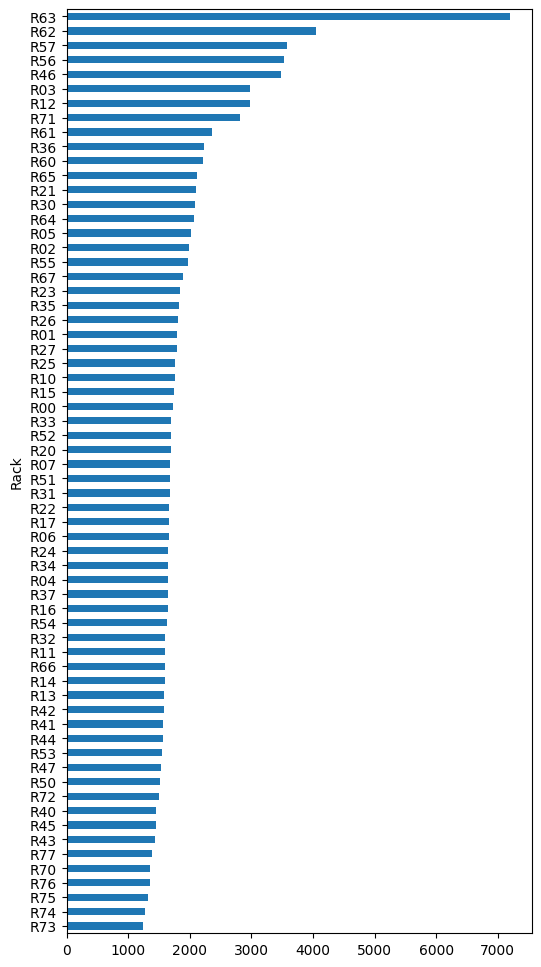

In [15]:
plt.figure(figsize=(6,12))
df_bgl.groupby(by='Rack').Timestamp.count().sort_values().plot.barh()
plt.savefig("./img/components/BGL_System_Bar_Rack.svg", format = "svg")
plt.show()

Il sistema è fatto da 64 rack e gli errori sono distribuiti come nella figura sopra.
sotto si estraggono gli n rack con piu falliemnti, per fare analisi per i rack piu problematici.

In [16]:
n = 8 # l'ho provato per i primi 8 perché c'era roba interessante, pero poi le reliability fanno un po schifo
top_rack = df_bgl.groupby(by=['Rack']).Timestamp.count().sort_values(ascending=False)[0:n].index

df_top_rack = df_bgl.loc[df_bgl['Rack'] == top_rack[0]]
for r in range(1,n):
    df_top_rack = df_top_rack.append(df_bgl.loc[df_bgl['Rack'] == top_rack[r]])

/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/1876088232.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_top_rack = df_top_rack.append(df_bgl.loc[df_bgl['Rack'] == top_rack[r]])
/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/1876088232.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_top_rack = df_top_rack.append(df_bgl.loc[df_bgl['Rack'] == top_rack[r]])
/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/1876088232.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_top_rack = df_top_rack.append(df_bgl.loc[df_bgl['Rack'] == top_rack[r]])
/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/1876088232.py:6: FutureWarning: The frame.append method is d

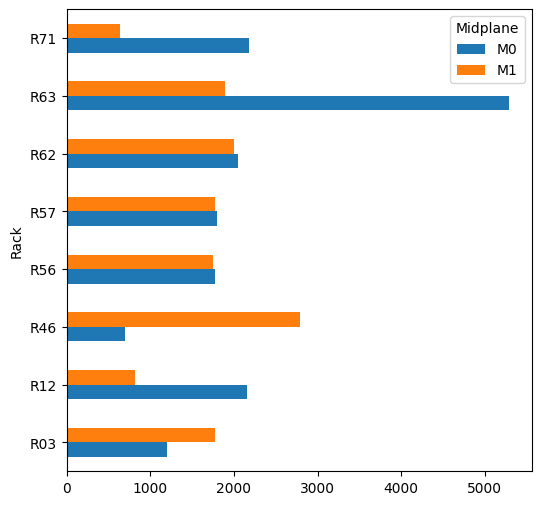

In [17]:
# df_bgl.groupby(by=['Rack', 'Midplane']).Timestamp.count().unstack(1).plot.barh(figsize=(6,15))
df_top_rack.groupby(by=['Rack', 'Midplane']).Timestamp.count().unstack(1).plot.barh(figsize=(6,6))
plt.savefig("./img/components/BGL_Rack_Bar_Rack_Midplane.svg", format = "svg")
plt.show()

ogni rack ha 2 midplane. gli errori trai midplane sono piu o meno bilanciati tranne qualcuno.
il 63 che rompe il cazzo piu di tutti ha un midplain che va a puttane.

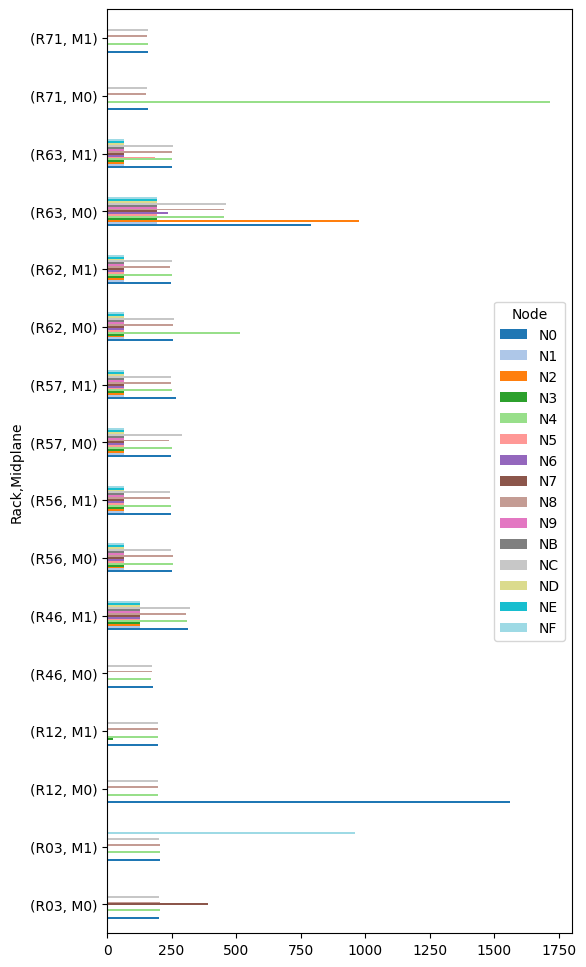

In [18]:
# df_bgl.groupby(by=['Rack', 'Midplane', 'Node']).Timestamp.count().unstack(2).plot.barh(figsize=(15,35), cmap = 'tab20')
df_top_rack.groupby(by=['Rack', 'Midplane', 'Node']).Timestamp.count().unstack(2).plot.barh(figsize=(6,12), cmap = 'tab20')
plt.savefig("./img/components/BGL_Rack_Bar_Rack_Midplane_Node.svg", format = "svg")
plt.show()

sicuramente è più leggibile se fatto solo per i top 5 rack, ma cmq si nota che:
- r63 fa cacare un po tutto, non c è un singolo nodo che si sputtana
- r71 ha il nodo con piu fallimenti di tutto il sistema, tipo un N4 che fa IO
- r12 pure non scherza, sempre un nodo di IO (N0)
- r03 pure si rompe un nodo di computation
- tutti i nodi hanno errori sui 4 nodi che hanno scheda di IO (azzurro n0 verde n4 marrone n8 ocra nC)

## Data Manipulation

### Temporal coalescence

#### Sensitivity analysis

In [19]:
c_wins = np.delete(np.arange(0,500,1), 0)

for rack in top_rack:
    df_temp = df_bgl.loc[df_bgl['Rack'] == rack]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = './data/components/BGL-' + rack + '-Sensitivity.csv'
    sensitivity_analysis(df_temp, c_wins, filepath)

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!



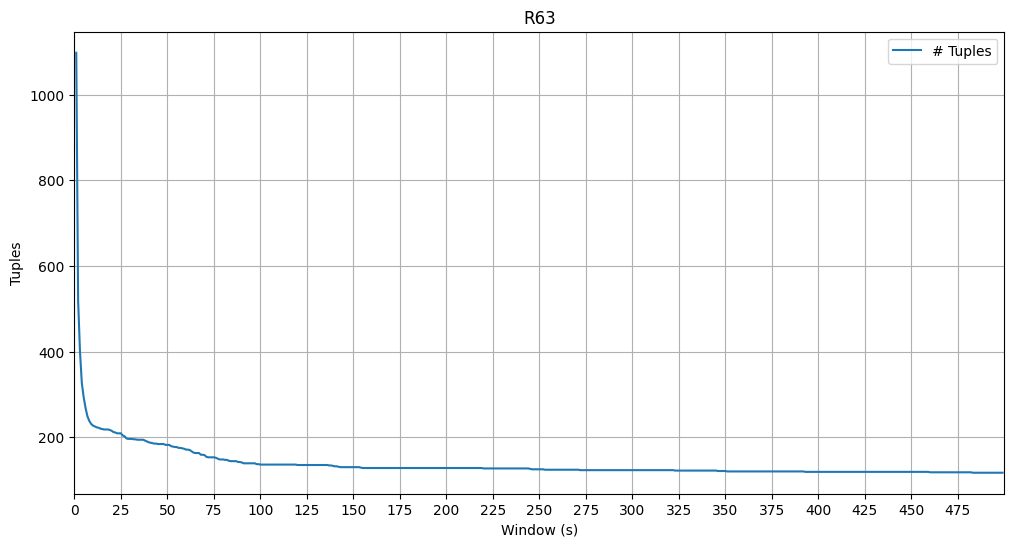

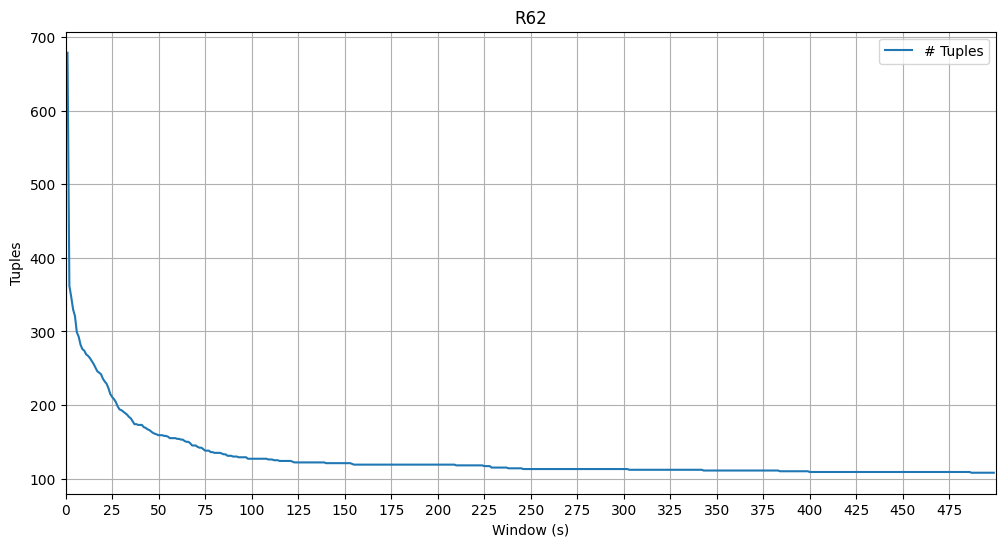

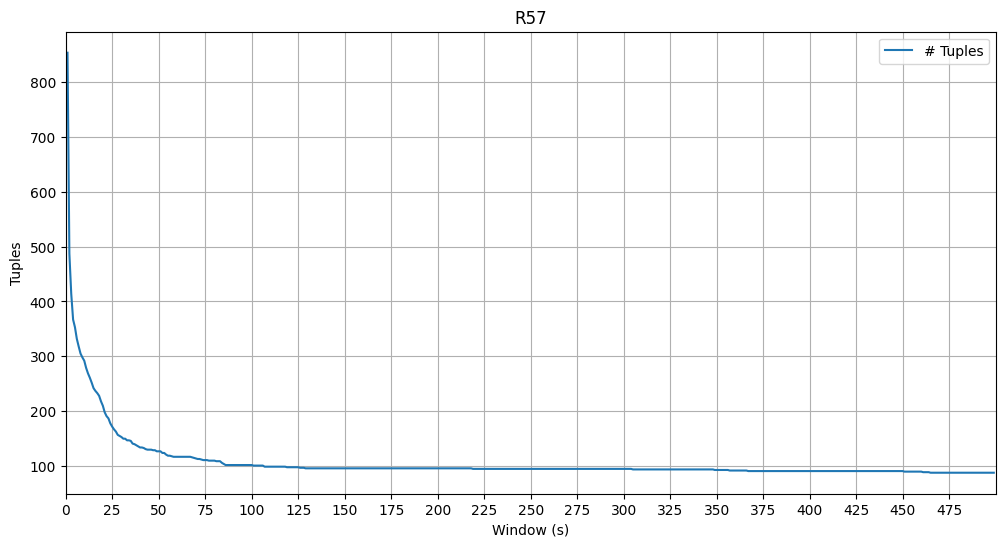

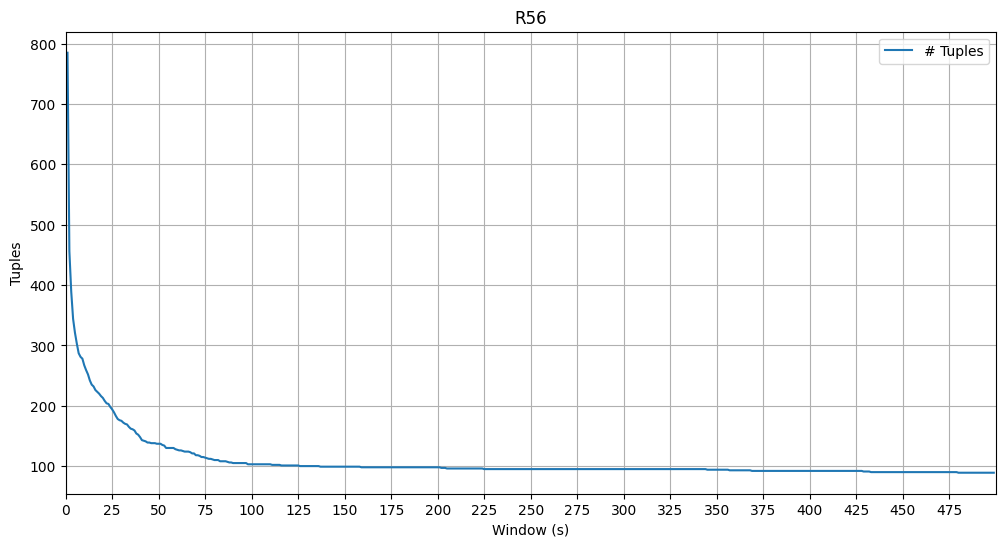

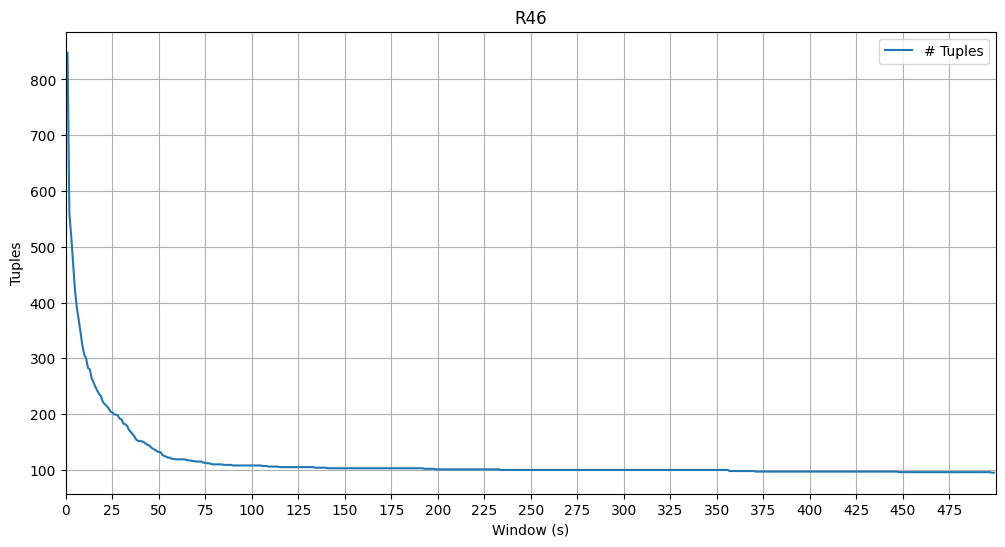

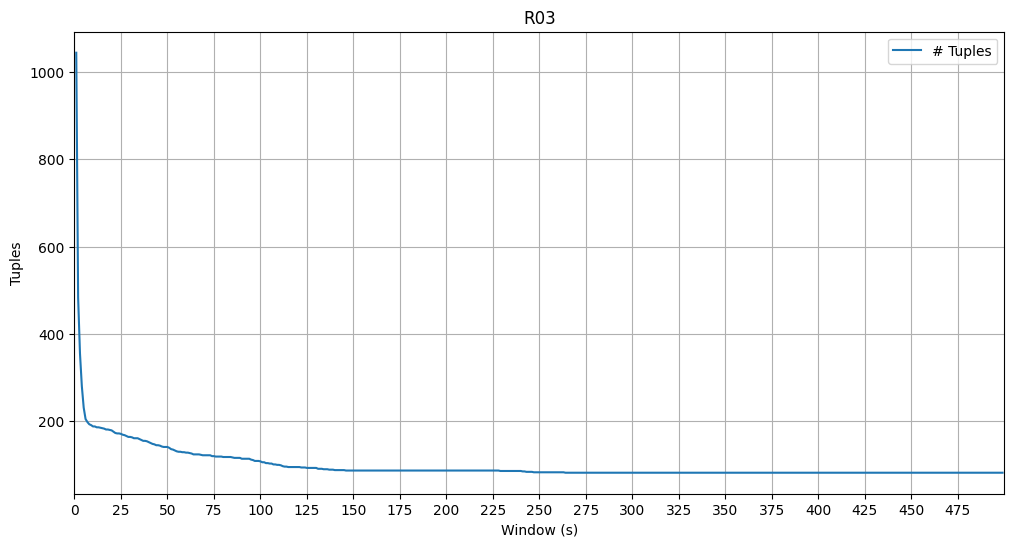

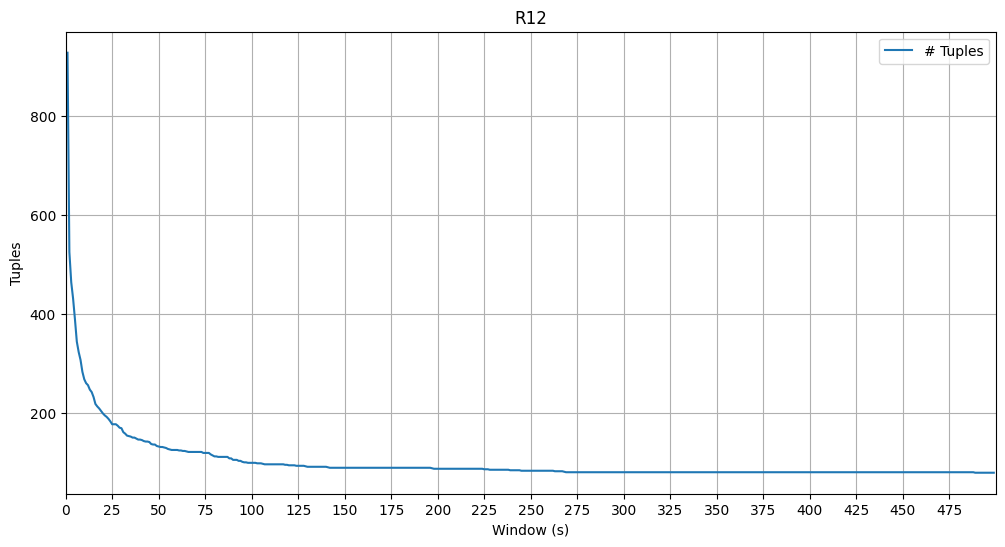

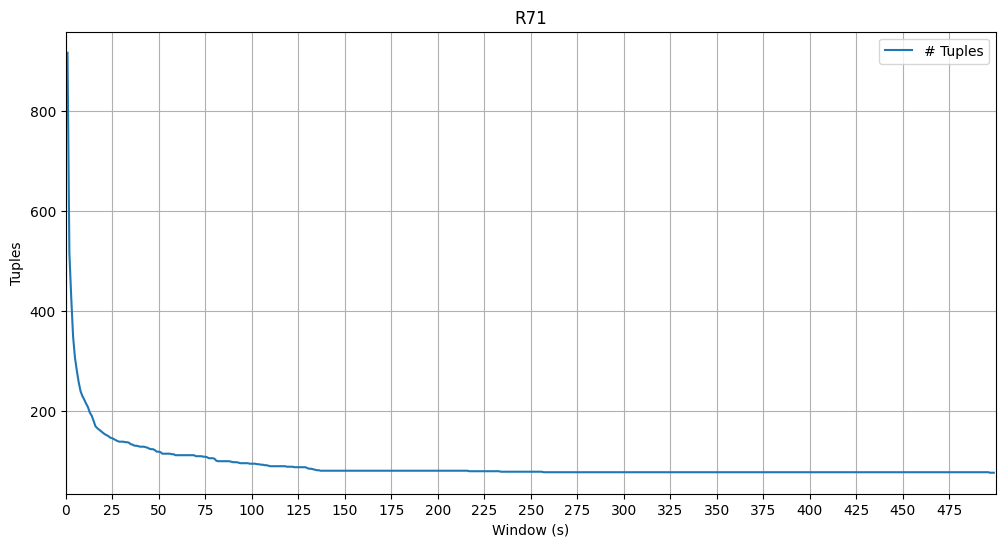

In [20]:
for rack in top_rack:
    filepath = './data/components/BGL-' + rack + '-Sensitivity.csv'
    
    df_temp_sensitivity = pd.read_csv(filepath, index_col = 0)
    
    x = df_temp_sensitivity['Window']
    y = df_temp_sensitivity['Tuples']
    
    plt.figure(figsize=(12,6))
    plt.plot(x, y, label = '# Tuples')
    plt.title(rack)
    plt.xlim(0,500)
    plt.xticks(np.arange(0, 500, step = 25))
    plt.xlabel('Window (s)')
    plt.ylabel('Tuples')
    plt.legend()
    plt.grid()
    plt.savefig("./img/components/BGL_Rack_Sensitivity_" + rack + ".svg", format = "svg")
    plt.show()

In [21]:
win_dict = {'R63' : 75,
            'R62' : 75,
            'R56' : 75,
            'R57' : 75,
            'R46' : 75,
            'R03' : 75,
            'R12' : 75,
            'R71'  : 75}
print('Selected coalescence windows:', win_dict)

Selected coalescence windows: {'R63': 75, 'R62': 75, 'R56': 75, 'R57': 75, 'R46': 75, 'R03': 75, 'R12': 75, 'R71': 75}


#### Tupling

In [22]:
dict_df_rack_stat = {}
dict_rack_num_tup = {}

for rack in top_rack:
    df_temp = df_bgl.loc[df_bgl['Rack'] == rack]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = './data/components/BGL-' + rack + '-Data.csv'
    
    df_tupling = tupling(df_temp, win_dict[rack], filepath)
    num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1
    dict_rack_num_tup[rack] = num_tup
    
    df_stat = statistics(df_tupling)
    dict_df_rack_stat[rack] = df_stat

print('Number of tuples:', dict_rack_num_tup)

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!

Number of tuples: {'R63': 153, 'R62': 138, 'R57': 111, 'R56': 114, 'R46': 113, 'R03': 120, 'R12': 119, 'R71': 109}


/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/751595383.py:11: FutureWarning: The default value of numeric_only in DataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1
/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/1049074867.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(df_stat, ignore_index = True)
/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/751595383.py:11: FutureWarning: The default value of numeric_only in DataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of 

## Data Analysis

### Empirical reliability

In [24]:
for rack in top_rack:

    ecdf = ECDF(dict_df_rack_stat[rack]['Interarrival'].dropna())

    tempi_int = pd.DataFrame(dict_df_rack_stat[rack]['Interarrival'].dropna().to_numpy(), columns=['tempi interarrivo'])
    np.savetxt(r'./scripts_matlab/components/tempi_int'+rack+'.txt', tempi_int, fmt='%d')

df = pd.DataFrame(top_rack)
df.to_excel('./scripts_matlab/components/names.xls')


/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/4251877771.py:9: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  df.to_excel('./scripts_matlab/components/names.xls')


# Card Types

In [25]:
types = df_bgl['Card type'].unique()

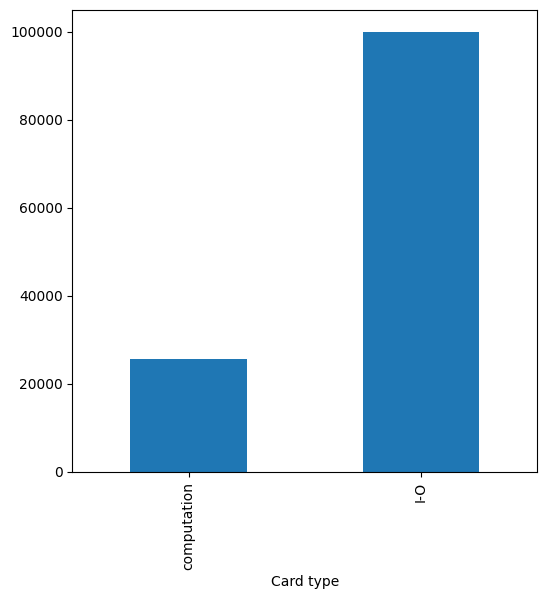

In [26]:
plt.figure(figsize=(6,6))
df_bgl.groupby(by='Card type').Timestamp.count().sort_values().plot.bar(figsize=(6,6))
plt.savefig("./img/types/BGL_Card_Bar_Type.svg", format = "svg")
plt.show()

sopra si vede che fondamentamente ci sono problemi con il sistema di IO.

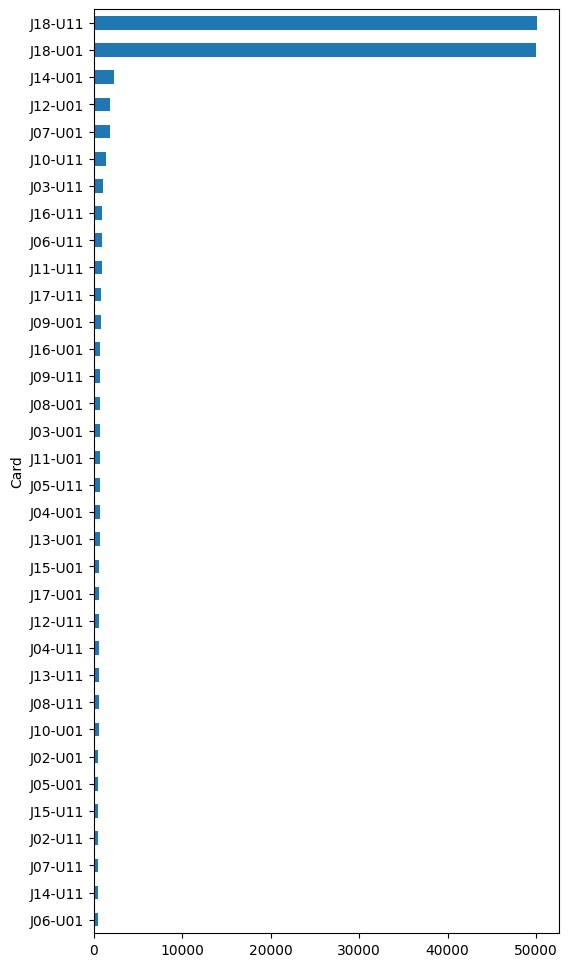

In [27]:
plt.figure(figsize=(6,12))
df_bgl.groupby(by='Card').Timestamp.count().sort_values().plot.barh(figsize=(6,12))
plt.savefig("./img/types/BGL_Card_Bar_Node.svg", format = "svg")
plt.show()

gli errori sono bilanciati tra le due card di ogni tipologia.

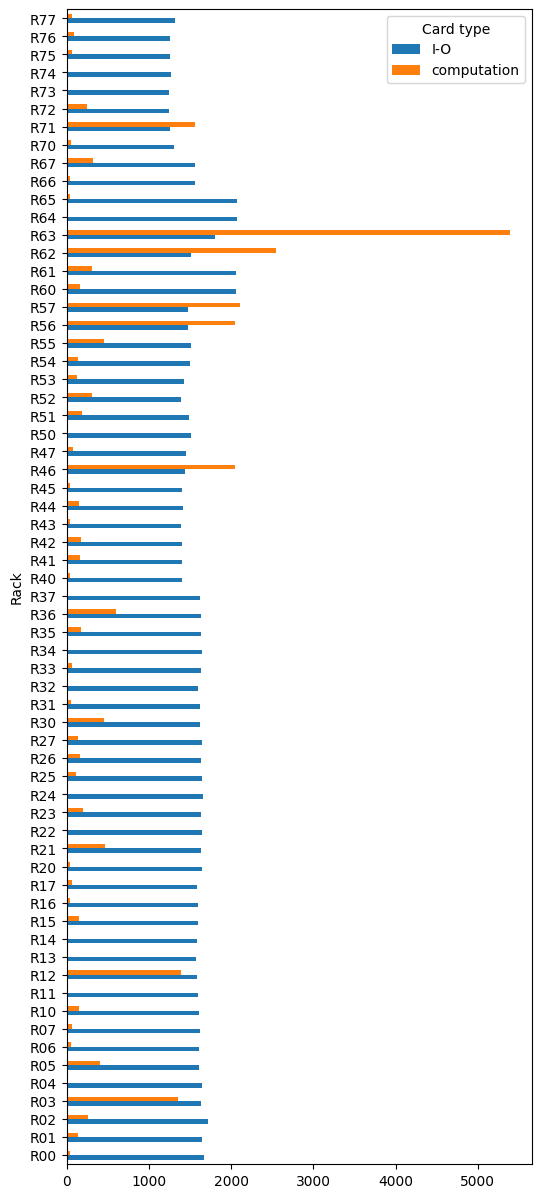

In [28]:
df_bgl.groupby(by=['Rack','Card type']).Timestamp.count().unstack(1).plot.barh(figsize=(6,15))
plt.savefig("./img/types/BGL_Card_Bar_Rack_Type.svg", format = "svg")
plt.show()

da questa immagine vediamo che i problemi di IO sono comuni a quasi tutti i rack.
un altro fatto interessante è che i rack più critici non hanno solo problemi con l'IO ma anche  con le card di computation

## Data Manipulation

### Temporal coalescence

#### Sensitivity analysis

In [29]:
c_wins = np.delete(np.arange(0,500,1), 0)

for t in types:
    df_temp = df_bgl.loc[df_bgl['Card type'] == t]
    df_temp.reset_index(drop = True, inplace = True)
    
    filepath = './data/types/BGL-' + t + '-Sensitivity.csv'
    
    sensitivity_analysis(df_temp, c_wins, filepath)

File already exists!

File already exists!



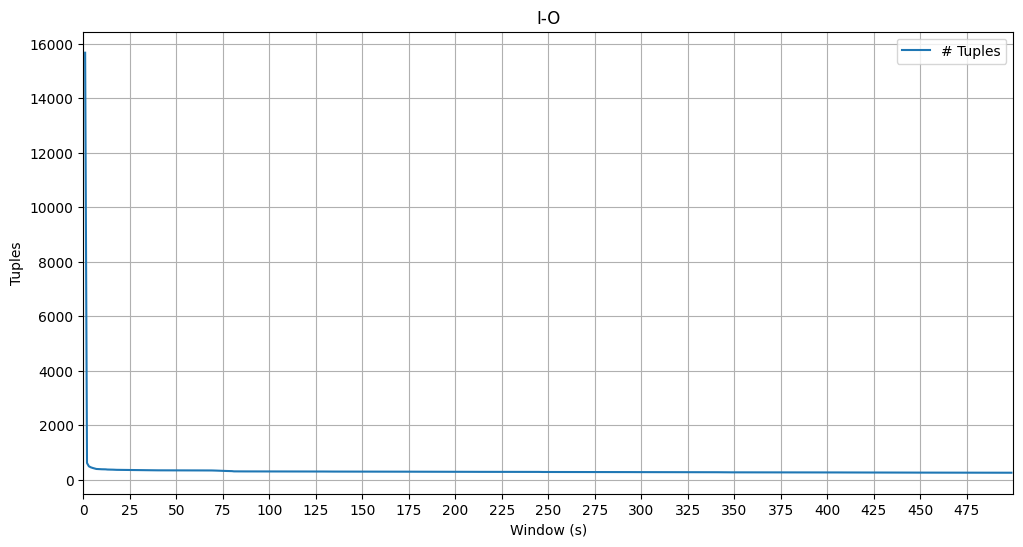

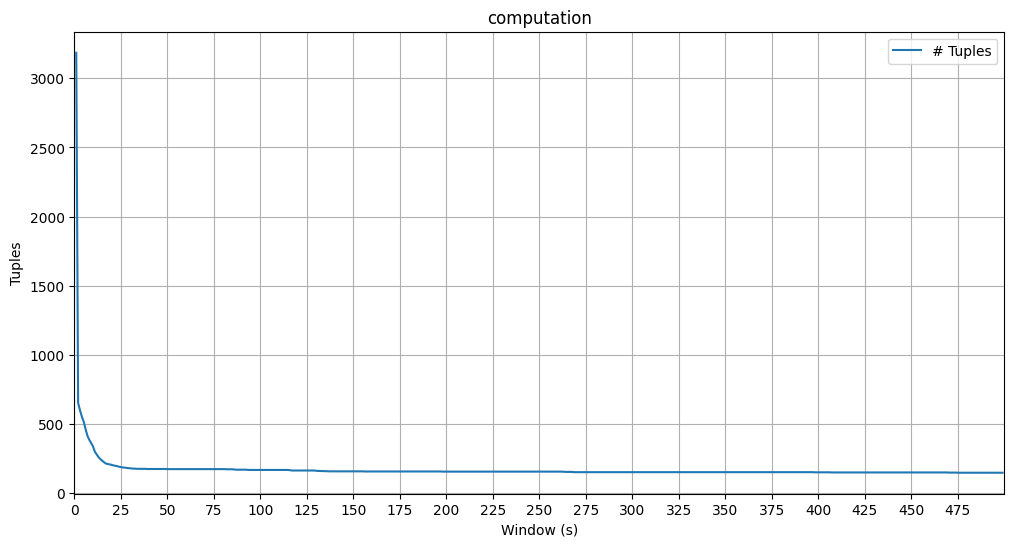

In [30]:
for t in types:
    filepath = './data/types/BGL-' + t + '-Sensitivity.csv'
    
    df_temp_sensitivity = pd.read_csv(filepath, index_col = 0)
    
    x = df_temp_sensitivity['Window']
    y = df_temp_sensitivity['Tuples']
    
    plt.figure(figsize=(12,6))
    plt.plot(x, y, label = '# Tuples')
    plt.title(t)
    plt.xlim(0,500)
    plt.xticks(np.arange(0, 500, step = 25))
    plt.xlabel('Window (s)')
    plt.ylabel('Tuples')
    plt.legend()
    plt.grid()
    plt.savefig("./img/types/BGL_Card_Sensitivity" + t +".svg", format = "svg")
    plt.show()

In [31]:
win_dict = {'I-O' : 10,
            'computation' : 20}
print('Selected coalescence windows:', win_dict)

Selected coalescence windows: {'I-O': 10, 'computation': 20}


#### Tupling

In [32]:
dict_df_type_stat = {}
dict_type_num_tup = {}

for t in types:
    df_temp = df_bgl.loc[df_bgl['Card type'] == t]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = './data/types/BGL-' + t + '-Data.csv'
    
    df_tupling = tupling(df_temp, win_dict[t], filepath)
    num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1
    dict_type_num_tup[t] = num_tup
    
    df_stat = statistics(df_tupling)
    dict_df_type_stat[t] = df_stat

print('Number of tuples:', dict_type_num_tup)

File already exists!

File already exists!

Number of tuples: {'I-O': 380, 'computation': 204}


/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/1049074867.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(df_stat, ignore_index = True)
/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/950967665.py:11: FutureWarning: The default value of numeric_only in DataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1
/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/1049074867.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(df_stat, ignore_index = True)


## Data Analysis

### Empirical reliability

In [34]:
for t in types:

    ecdf = ECDF(dict_df_type_stat[t]['Interarrival'].dropna())

    tempi_int = pd.DataFrame(dict_df_type_stat[t]['Interarrival'].dropna().to_numpy(), columns=['tempi interarrivo'])
    np.savetxt(r'./scripts_matlab/types/tempi_int'+t+'.txt', tempi_int, fmt='%d')

df = pd.DataFrame(types)
df.to_excel('./scripts_matlab/types/names.xls')


/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/1442999936.py:9: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  df.to_excel('./scripts_matlab/types/names.xls')


# Top Nodes

In [35]:
print('Number of nodes that generates error: ' + str(len(df_bgl['ID-Node'].unique())))

Number of nodes that generates error: 698


In [36]:
n = 5

top_node = df_bgl.groupby(by=['ID-Node']).Timestamp.count().sort_values(ascending=False)[0:n].index

df_top_node = df_bgl.loc[df_bgl['ID-Node'] == top_node[0]]
for r in range(1,n):
    df_top_node = df_top_node.append(df_bgl.loc[df_bgl['ID-Node'] == top_node[r]])

/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/1494793635.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_top_node = df_top_node.append(df_bgl.loc[df_bgl['ID-Node'] == top_node[r]])
/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/1494793635.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_top_node = df_top_node.append(df_bgl.loc[df_bgl['ID-Node'] == top_node[r]])
/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/1494793635.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_top_node = df_top_node.append(df_bgl.loc[df_bgl['ID-Node'] == top_node[r]])
/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/1494793635.py:7: FutureWarning: The frame.append me

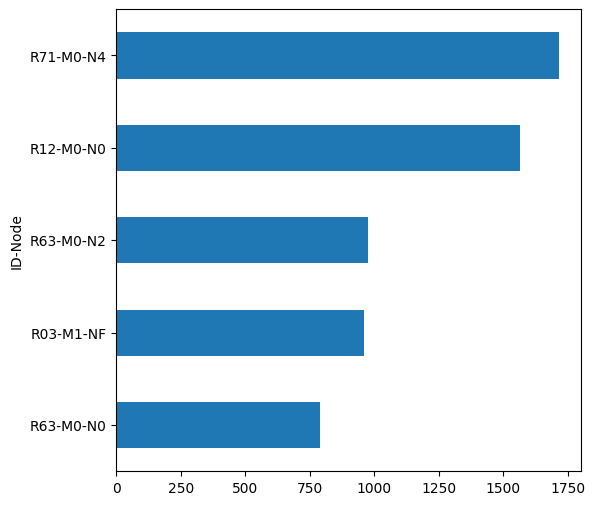

In [37]:
df_top_node.groupby(by='ID-Node').Timestamp.count().sort_values(ascending=True).plot.barh(figsize=(6,6))
plt.savefig("./img/nodes/BGL_Node_Bar.svg", format = "svg")
plt.show()

## Data Manipulation

### Temporal coalescence

#### Sensitivity analysis

In [38]:
c_wins = np.delete(np.arange(0,500,1), 0)

for node in top_node:
    df_temp = df_bgl.loc[df_bgl['ID-Node'] == node]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = './data/nodes/BGL-' + node + '-Sensitivity.csv'
    sensitivity_analysis(df_temp, c_wins, filepath)

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!



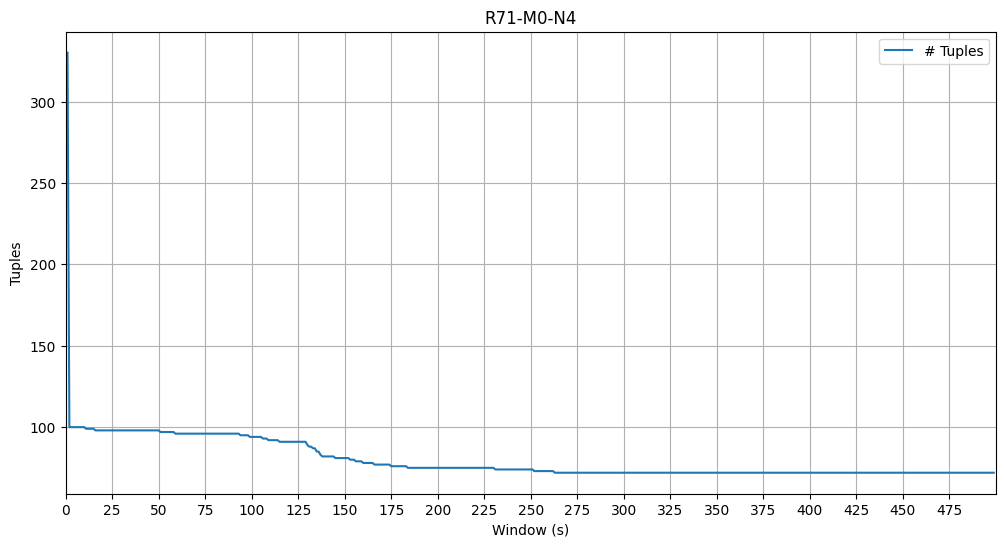

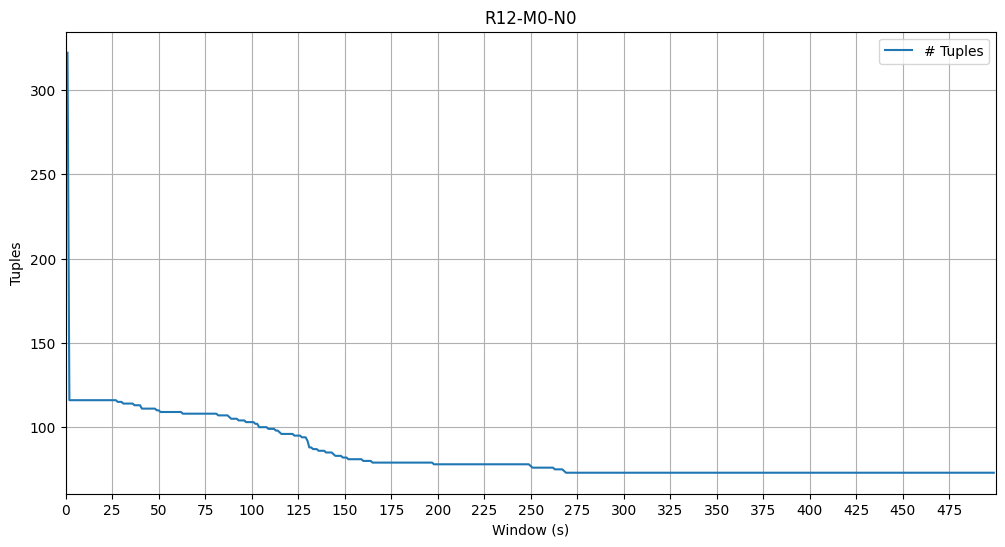

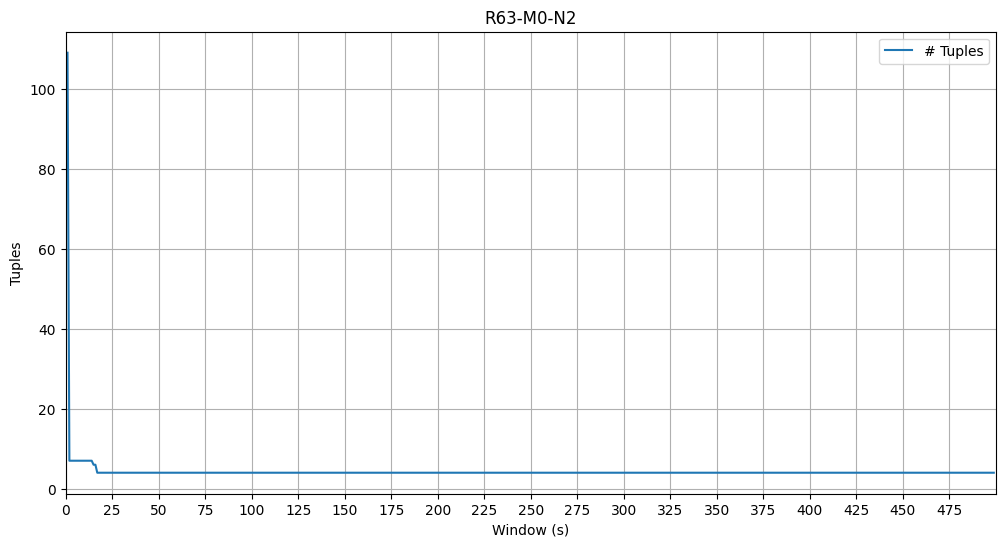

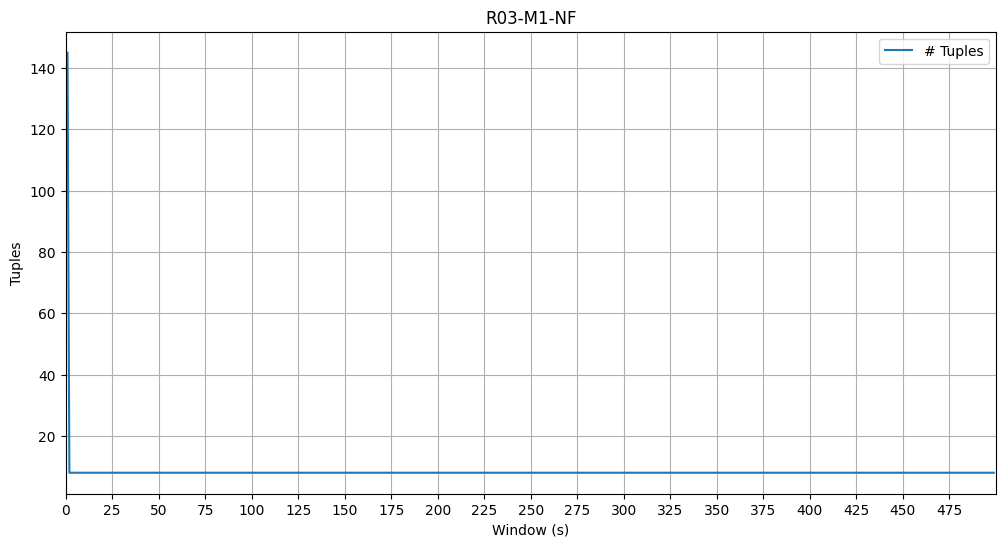

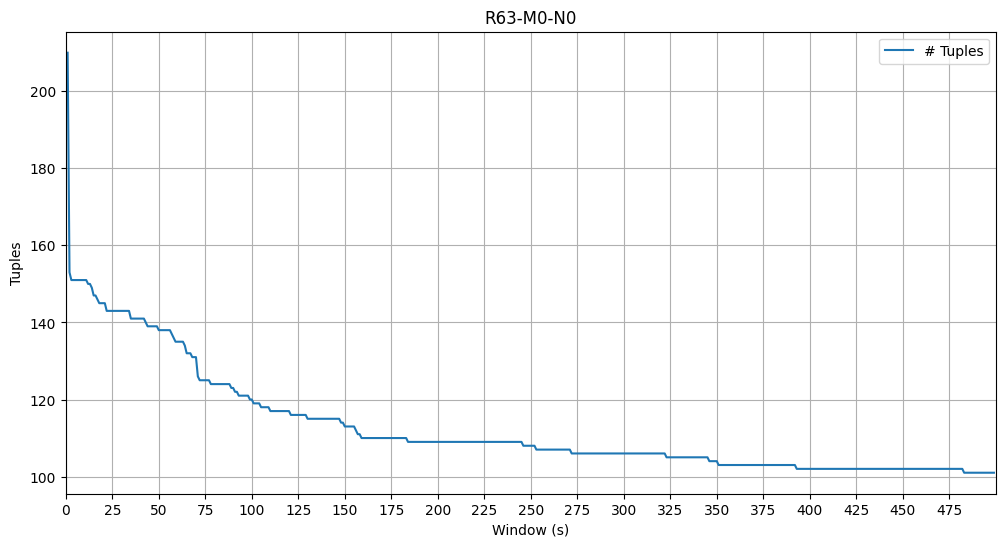

In [39]:
# x_dict = {'tg-c401' : 500,
#           'tg-master' : 500,
#           'tg-c572' : 500,
#           'tg-s044' : 500,
#           'tg-c238' : 500}

for node in top_node:
    filepath = './data/nodes/BGL-' + node + '-Sensitivity.csv'
    
    df_temp_sensitivity = pd.read_csv(filepath, index_col = 0)
    
    x = df_temp_sensitivity['Window']
    y = df_temp_sensitivity['Tuples']
    
    plt.figure(figsize=(12,6))
    plt.plot(x, y, label = '# Tuples')
    plt.title(node)
    plt.xlim(0,500)
    plt.xticks(np.arange(0, 500, step = 25))
    plt.xlabel('Window (s)')
    plt.ylabel('Tuples')
    plt.legend()
    plt.grid()
    plt.savefig("./img/nodes/BGL_Node_Sensitivity" + node +".svg", format = "svg")
    plt.show()

In [40]:
win_dict = {'R71-M0-N4' : 175,
            'R12-M0-N0' : 175,
            'R63-M0-N2' : 10,
            'R03-M1-NF' : 5,
            'R63-M0-N0' : 175}

print('Selected coalescence windows:', win_dict)

Selected coalescence windows: {'R71-M0-N4': 175, 'R12-M0-N0': 175, 'R63-M0-N2': 10, 'R03-M1-NF': 5, 'R63-M0-N0': 175}


#### Tupling

In [41]:
dict_df_node_stat = {}
dict_node_num_tup = {}

for node in top_node:
    df_temp = df_bgl.loc[df_bgl['ID-Node'] == node]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = './data/nodes//BGL-' + node + '-Data.csv'
   
    df_tupling = tupling(df_temp, win_dict[node], filepath)
    num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1
    dict_node_num_tup[node] = num_tup
    
    df_stat = statistics(df_tupling)
    dict_df_node_stat[node] = df_stat
    
print('Number of tuples:', dict_node_num_tup)

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!

Number of tuples: {'R71-M0-N4': 76, 'R12-M0-N0': 79, 'R63-M0-N2': 7, 'R03-M1-NF': 8, 'R63-M0-N0': 110}


/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/1049074867.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(df_stat, ignore_index = True)
/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/1049074867.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(df_stat, ignore_index = True)
/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/1049074867.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(df_stat, ignore_index = True)
/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/1049074867.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

## Data Analysis

### Empirical reliability

In [42]:
top_tup_node = [k for k in dict_node_num_tup if dict_node_num_tup[k] > 30]

for node in top_tup_node:
    ecdf = ECDF(dict_df_node_stat[node]['Interarrival'].dropna())

    tempi_int = pd.DataFrame(dict_df_node_stat[node]['Interarrival'].dropna().to_numpy(), columns=['tempi interarrivo'])
    np.savetxt(r'./scripts_matlab/nodes/tempi_int'+node+'.txt', tempi_int, fmt='%d')

df = pd.DataFrame(top_tup_node)
df.to_excel('./scripts_matlab/nodes/names.xls')

/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/3132695421.py:10: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  df.to_excel('./scripts_matlab/nodes/names.xls')
